In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
import os

In [12]:
image_size = (299, 299, 3)
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=image_size,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Xception uses size (150, 150) - 23M
# InceptionResV2 uses size (299, 299) - Bigger model 56M

# Freeze the base_model
base_model.trainable = False

94765736/94765736 [==============================] - 12s 0us/step


In [13]:
base_model.input_shape

(None, 224, 224, 3)

In [14]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/Fusion"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Anger", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path_structured, 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred", 
    validation_split=0.05, 
    subset="both", 
    batch_size=64,
    image_size=image_size[:2],
    seed=101)

Found 40621 files belonging to 7 classes.
Using 38590 files for training.
Using 2031 files for validation.


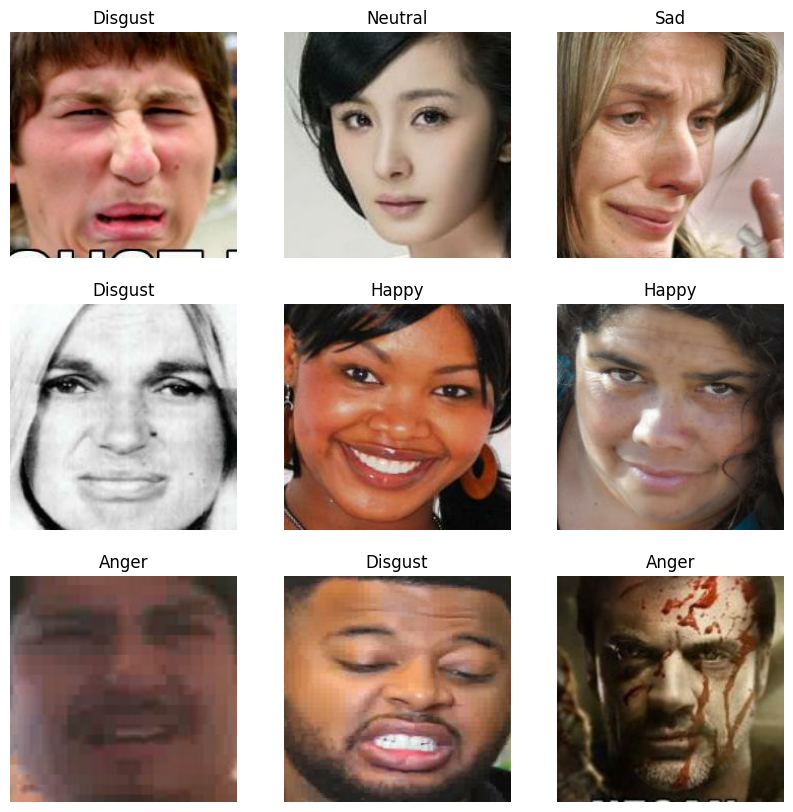

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

2023-11-16 09:31:09.965047: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


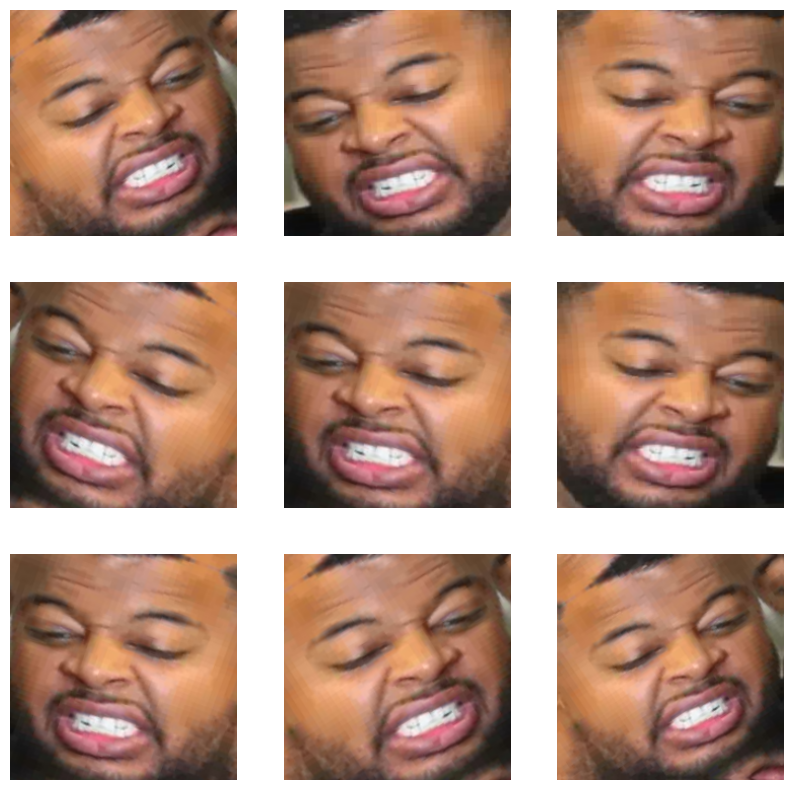

In [16]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [17]:
# Create new model on top
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Inception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(7)(x)
model = keras.Model(inputs, outputs)

In [18]:
# train 10 epochs for every two layers recurssivly unfrozen 
# SPECIFY LEARNING RATE
base_learning_rate = 0.001

model.summary()
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [19]:
model.save('AffectInceptionResNetV2-1.keras')

In [25]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers)) 

def train_recursive(count, current_epochs, hist, epochs=1):
    # Number of layers to fine tune
    fine_tune_final = count
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[len(base_model.layers) - fine_tune_final:]:
      layer.trainable = False
    
    print(i)
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate/10),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    history_fine = model.fit(train_ds,
                             epochs=current_epochs + epochs,
                             initial_epoch=hist.epoch[-1],
                             validation_data=val_ds)
    return history_fine

Number of layers in the base model:  175


In [21]:
total_epochs = 1
init_epochs = 1
train_history = model.fit(train_ds, epochs=init_epochs, validation_data=validation_ds)

603/603 [==============================] - 640s 1s/step - loss: 0.4152 - categorical_accuracy: 0.1702 - val_loss: 0.4067 - val_categorical_accuracy: 0.1649


In [ ]:
for layer_count in range(1, 3):
    print(layer_count)

fine_tune_epochs = 10

Epoch 1/2
603/603 [==============================] - 2358s 4s/step - loss: 0.4351 - categorical_accuracy: 0.1412 - val_loss: 0.4105 - val_categorical_accuracy: 0.1388
Epoch 2/2
603/603 [==============================] - 2296s 4s/step - loss: 0.4118 - categorical_accuracy: 0.1412 - val_loss: 0.4106 - val_categorical_accuracy: 0.1457
Epoch 2/3
603/603 [==============================] - 2240s 4s/step - loss: 0.4126 - categorical_accuracy: 0.1434 - val_loss: 0.4104 - val_categorical_accuracy: 0.1457
Epoch 3/3
 70/603 [==>...........................] - ETA: 33:01 - loss: 0.4112 - categorical_accuracy: 0.1431

In [23]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']
# 
# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

In [24]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(init_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'accuracy'

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
img = tf.keras.utils.load_img("Affective_Computing/Sample_Images/Ben Glasses.png", target_size=(299, 299))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

scores = model.decode_predictions(
    predictions
)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)